# SCRAPY

Per cominciare il progetto, iniziamo importando i file csv all'interno di dei dataframe pandas

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import warnings

# Disable all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [76]:

dataset_path = "./dataset/"

def load_data(dataset_path):
    inputs = pd.read_csv(dataset_path + "inputs.csv", header=None)
    outputs = pd.read_csv(dataset_path + "outputs.csv", header=None)
    mapping = pd.read_csv(dataset_path + "mapping.csv", header=None)
    transactions = pd.read_csv(dataset_path + "transactions.csv", header=None)
    return inputs, outputs, mapping, transactions


print("Loading data...")
inputs, outputs, mapping, transactions = load_data(dataset_path)
print("Done...")

Loading data...
Done...


### Preprocessing
La prima cosa evidente quando leggo questi CSV, è che non è presenti i column name nei file, dunque per comodità, seguendo la traccia li aggiungerò io.

In aggiunta, downscalerò i tipi default (np.int64) alla minore grandezza possibile, così da risparmiare memoria e quindi tempo nelle operazioni.

In [77]:
print("Adding headers to the dataframes...")
# headers transaction
transactions.columns = ["timestamp", "blockId", "txId", "isCoinbase", "fee"]
# headers mapping
mapping.columns = ["addressId", "hash"]
# headers inputs
inputs.columns = ["txId", "prevTxId", "prevTxpos"]
# headers outputs
outputs.columns = ["txId", "position", "addressId", "amount", "scripttype"]
print("Done...")


# In aggiunta, andrò a downcastare ad int16 i campi che posso
# Questo downcast è possibile in quanto i valori presenti nei campi sono tutti numeri interi
# Andrà in automatico al valore minimo possibile per quel campo
print("Downcasting data...")
# Transactions
transactions['timestamp'] = pd.to_numeric(transactions['timestamp'], downcast='integer')
transactions['blockId'] = pd.to_numeric(transactions['blockId'], downcast='integer')
transactions['txId'] = pd.to_numeric(transactions['txId'], downcast='integer')
transactions['fee'] = pd.to_numeric(transactions['fee'], downcast='integer')

# Convert isCoinbase to categorical if it's binary
transactions['isCoinbase'] = transactions['isCoinbase'].astype('category')

# Inputs
inputs['txId'] = pd.to_numeric(inputs['txId'], downcast='integer')
inputs['prevTxId'] = pd.to_numeric(inputs['prevTxId'], downcast='integer')
inputs['prevTxpos'] = pd.to_numeric(inputs['prevTxpos'], downcast='integer')

# Outputs
outputs['txId'] = pd.to_numeric(outputs['txId'], downcast='integer')
outputs['position'] = pd.to_numeric(outputs['position'], downcast='integer')
outputs['addressId'] = pd.to_numeric(outputs['addressId'], downcast='integer')
outputs['amount'] = pd.to_numeric(outputs['amount'], downcast='integer')
outputs['scripttype'] = outputs['scripttype'].astype('category')
print("Done...")

Adding headers to the dataframes...
Done...
Downcasting data...
Done...


### Informazioni dalla traccia
Andiamo a impostare alcune utilities per dopo

In [78]:
# Tutto quanto in bytes
scriptsizes = {
    0: 0,          #Unkown script, size 0...
    1: 153,        #P2PK, Una delle prime versione dello script di pagamento
    2: 180,        #P2PKH, Uno degli script di pagamento più comuni all'epoca
    3: 291         #P2PSH, A P2SH transaction is a transaction whose inputs were locked using a P2SH ScriptPubKey.
}
script_name_map = {
    0: "Unknown",
    1: "P2PK",
    2: "P2PKH",
    3: "P2PSH"
}
avg_input_size = 40     #Dimensione media di un input (da traccia)
avg_output_size = 9     #Dimensione media di un output (da traccia)

## Analisi di dati sulla blockchain
Una delle primissime analisi che ci prendiamo la premura di fare, è quella dell'andamento delle fees rispetto alla congestione della blockchain. Ovvero ci interessa capire se all'aumentare della congestione, aumentano anche le fees. 
La formula che ci restituisce la dimensione in byte di una transazione è la seguente:
$$ size(transaction) = size(input)*\text{n\_inputs} + size(output)* \text{n\_outputs} + size(script)$$
A questo punto la congestione non è altro che la somma delle dimensioni delle transazioni dato un intervallo di tempo. 
L'idea ora è mergiare le transaction, calcolando quanti input ed output ci sono per ognuna e mergiando il risultato del calcolo. A questo punto è importante anche mergiare la script_size corrispettiva (infierendola da uno degli output correlati) e poi calcolare la size della transaction in maniera il più possibile efficiente.
Poi analizzerò il risultato plottando il tutto in un grafico che avrà entrambi gli indici (fee e transaction_size) nello stesso plot, per accorgermi velocemente di eventuali relazioni. Potrei eventualmente anche calcolare la correlazione tra i due indici.

In [79]:
# Filtriamo prima per le sole transazioni non coinbase
print("Filtering non-coinbase transactions...")
non_coinbase_transactions = transactions[transactions['isCoinbase'] == 0]
print("Done...")
print(f"Removed {transactions.shape[0]-non_coinbase_transactions.shape[0]} coinbase transactions...")
# Calcolo del numero di input e output per ogni transazione
print("Computing the number of inputs and outputs for each transaction...")
input_counts = inputs[inputs["txId"].isin(non_coinbase_transactions["txId"])].groupby('txId').size().reset_index(name='n_inputs')
output_counts = outputs[outputs["txId"].isin(non_coinbase_transactions["txId"])].groupby('txId').size().reset_index(name='n_outputs')
print("Done...")

print(f"Number of transactions considered: {non_coinbase_transactions.shape[0]}")
print(f"Input counts len:{input_counts.shape[0]}")
print(f"Output counts len:{output_counts.shape[0]}")

# Ora posso permettermi di mergiare i conteggi con le transazioni (sempre sulle non_coinbase)
print("Merging the input and output counts with the transactions...")
non_coinbase_transactions = non_coinbase_transactions.merge(input_counts, on='txId', how='left').fillna(0)
non_coinbase_transactions = non_coinbase_transactions.merge(output_counts, on='txId', how='left').fillna(0) #Per sicurezza il fillna ce lo metto ma non dovrebbero esserci problemi alcuni
print("Done...")

# A questo punto sono interessato a capire qual è lo script utilizzato da una transazione.
# Per fare ciò, mi basta controllare il campo scripttype di outputs e fare un merge con le transazioni

print("Merging the script type with the transactions...")
non_coinbase_transactions = non_coinbase_transactions.merge(outputs[['txId', 'scripttype']].drop_duplicates(subset="txId"), on='txId', how='left') #Droppo i duplicati perchè non mi interessano
print("Done...")
#Ora posso prendermi la briga di associare ogni script al suo scriptsize con una map
print("Mapping the script type to the script size...")
non_coinbase_transactions['script_size'] = non_coinbase_transactions['scripttype'].map(scriptsizes).astype('int') #As int perchè devo farci delle operazioni su interi dopo
print("Done...")

#Adesso che ho n_inputs, n_outputs e script_size tutti nel dataframe non_coinbase_transactions (Ovvero tutte le transazioni non coinbase), posso calcolare la size di ogni transazione in maniera vettoriale e dunque efficente
print("Computing the size of the transactions...")
non_coinbase_transactions['size'] = (non_coinbase_transactions['n_outputs']+non_coinbase_transactions['script_size'])*avg_output_size + non_coinbase_transactions['n_inputs']*avg_input_size
print("Done...")

Filtering non-coinbase transactions...
Done...
Removed 214563 coinbase transactions...
Computing the number of inputs and outputs for each transaction...
Done...
Number of transactions considered: 10358266
Input counts len:10358266
Output counts len:10358266
Merging the input and output counts with the transactions...
Done...
Merging the script type with the transactions...
Done...
Mapping the script type to the script size...
Done...
Computing the size of the transactions...
Done...


Adesso che abbiamo con successo calcolato la size per ogni transazione, possiamo pensare a plottarle come vogliamo per portare avanti l'analisi. Inoltre possiamo calcolare un coeffiente di correlazione.

Number of blocks: 130652


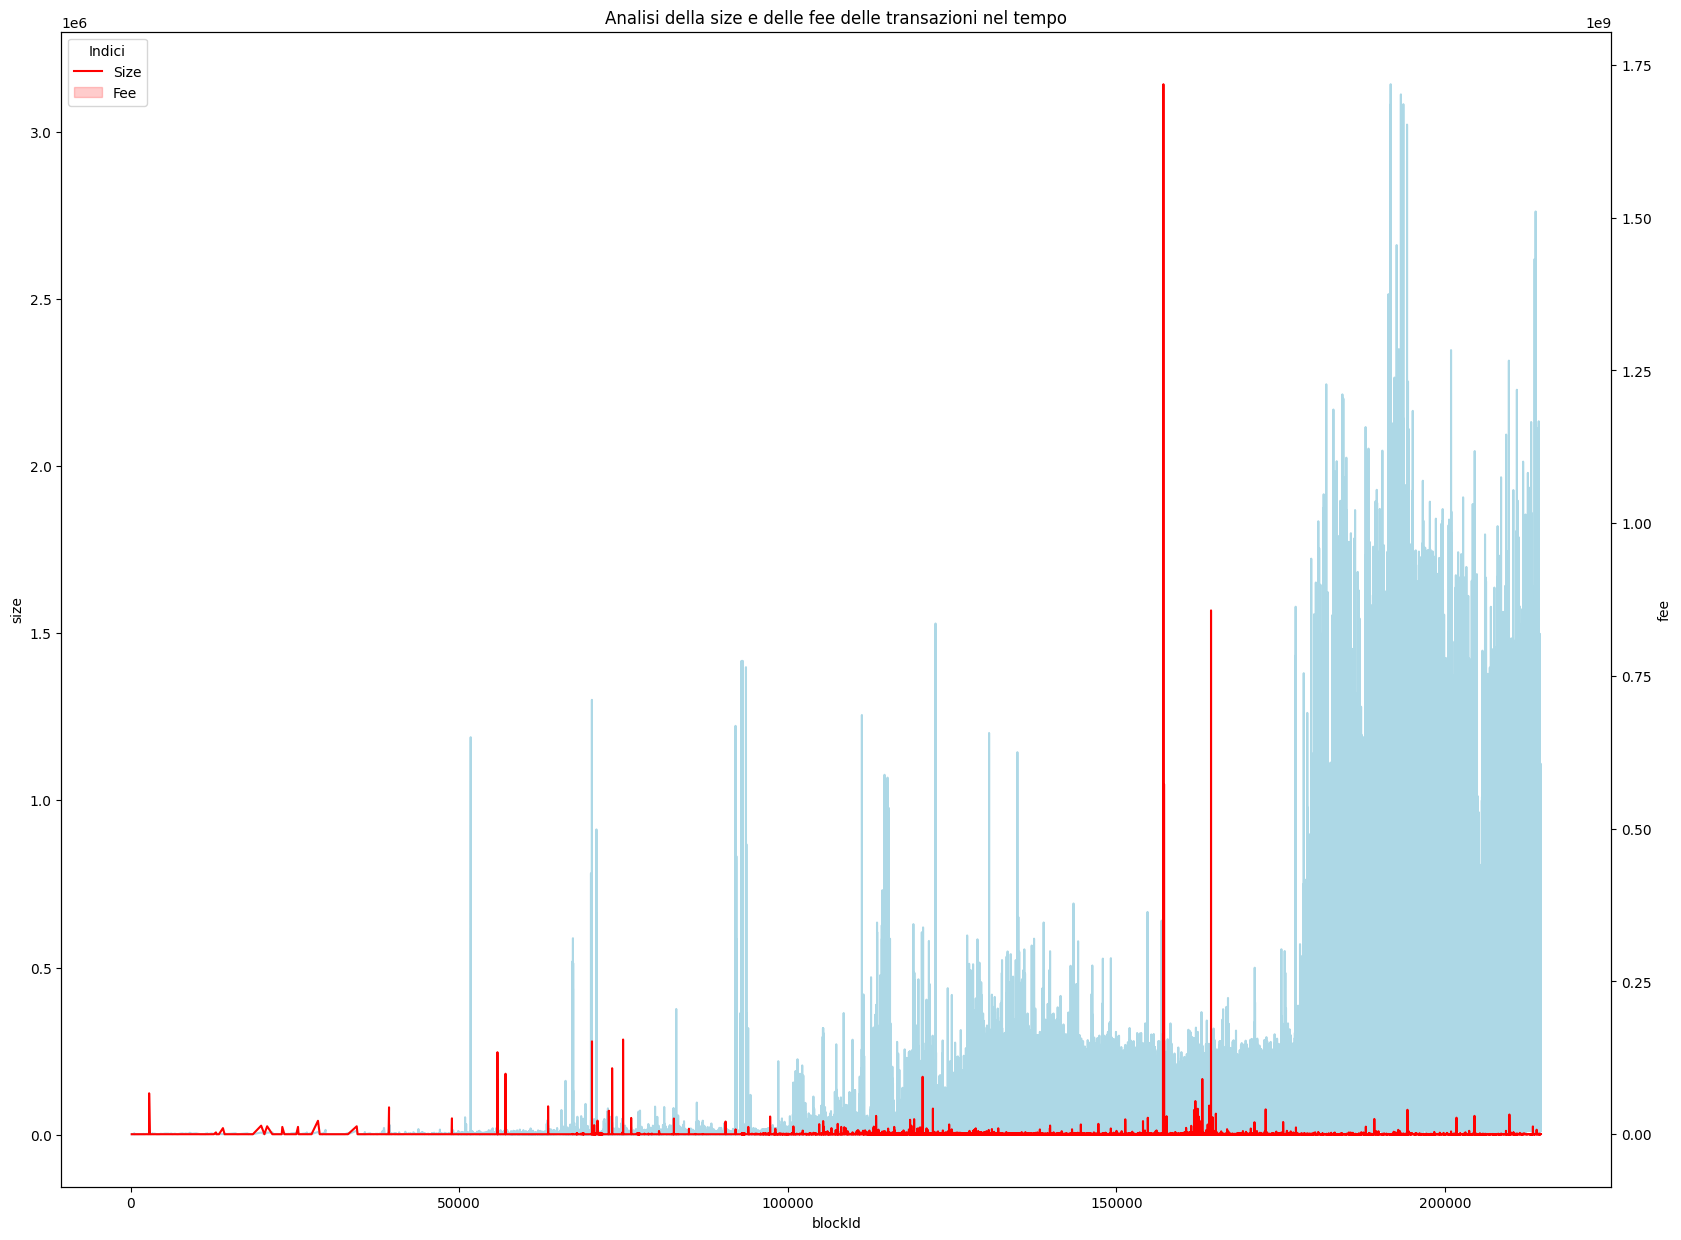

In [80]:
# Ci torna comodo trasformare il timestamp in un tipo data
non_coinbase_transactions['date'] = pd.to_datetime(non_coinbase_transactions['timestamp'], unit='s')
print("Number of blocks:", len(non_coinbase_transactions["blockId"].unique())) 
# Proviamo ad usare i blocchi come indice temporale, considerando che un blocco è un insieme di transazioni che avvengono in un certo intervallo di tempo e non può in nessun caso superare 1 milione di vbytes

# Gruppo per blockId e calcolo la somma delle transazioni per intervallo e la media delle fees 
grouped = non_coinbase_transactions.groupby("blockId").agg({ #Funzione di aggregazione
    'size': 'sum', #Somme delle size per intervallo, la congestione
    'fee': 'mean' #Media delle fee per intervallo, il costo medio di una transazione
}).reset_index()

# Proviamo a vedere separatamente come si comportano questi due indici in due grafici affiancati
fig, ax =plt.subplots() #Creo la figura
ax2 = ax.twinx() #Clono l'asse
fig.set_figheight(15)
fig.set_figwidth(20)
sns.lineplot(data=grouped, x='blockId', y='size', ax=ax, color='lightblue') 
sns.lineplot(data=grouped, x='blockId', y='fee', ax=ax2, color='red')
plt.legend(title="Indici", labels=['Size', 'Fee'], loc='upper left')
plt.title('Analisi della size e delle fee delle transazioni nel tempo')
plt.show()

In questo grafico vediamo come nel tempo la congestione è aumentata considerevolmente, dato l'immenso aumento di volume delle transazioni con il passare del tempo. In aggiunta, potremmo dire che il costo medio di una transazione segue vagamente la congestione del network, tuttavia c'è da considerare che con il passare degli anni, la potenza computazione a disposizione della blockchain è anch'essa aumentata a dismisura, mantendendo comunque relativamente stabile il costo delle fees.

Un'altro modo che abbiamo per renderci conto di quanto siano correlati questi due eventi, è chiederci matematicamente quanto la congestione sia correlata al costo medio delle fees. Per farlo, pandas ci mette a disposizione .corr(), che calcola il coefficiente matematico di correlazione tra due colonne. (Direttamente dalla statistica)

In [81]:
correlation = grouped['size'].corr(grouped['fee'])
print(f"Correlation between size and fee computed by pandas: {correlation}")

Correlation between size and fee computed by pandas: -0.005768861782663153


## Analisi dell'utilizzo dei diversi tipi di script presenti nel dataset nei primi 3 anni di vita della blockchain

Filtering the transactions for the first 3 years...
Done...
Currently working with 2119779 transactions...
Merging the script type with the transactions...
Done...
Mapping the script type to the script name...
Done...
script_name
P2PKH      1901503
P2PK        218262
Unknown         14
P2PSH            0
Name: count, dtype: int64


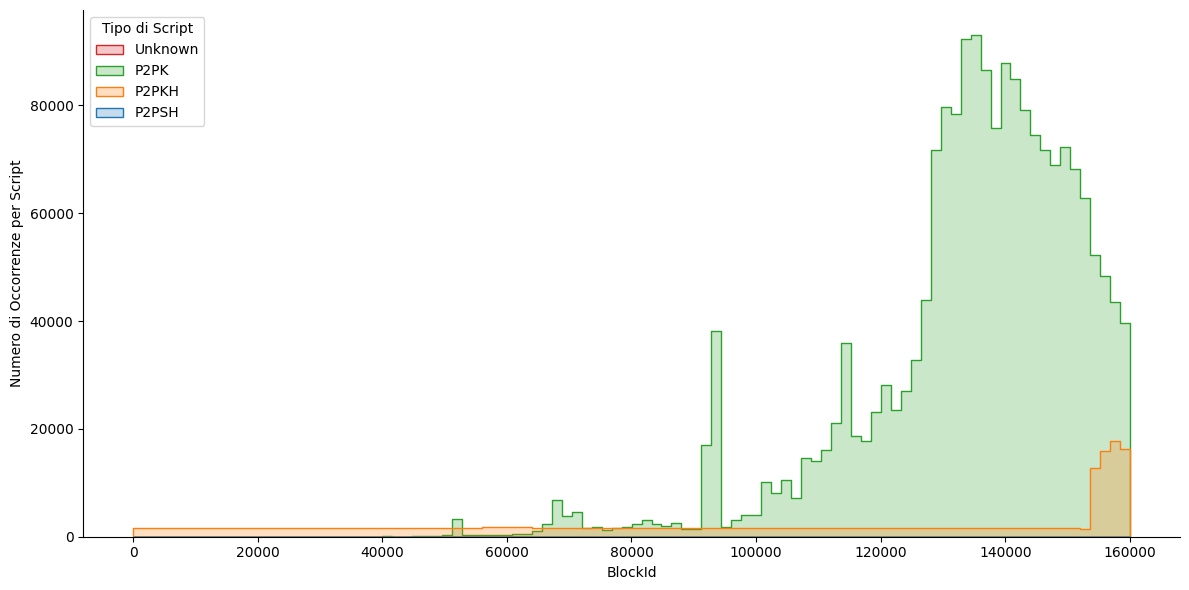

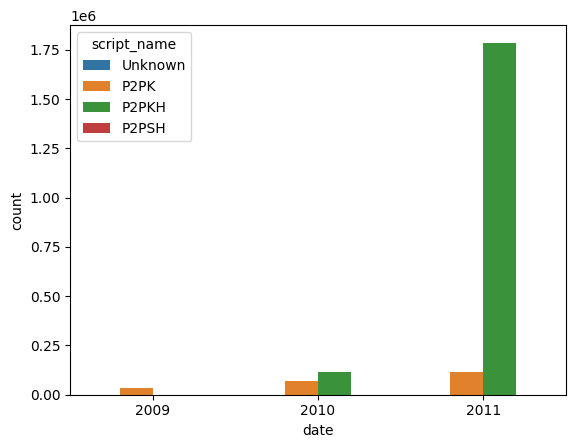

In [94]:
transactions['date'] = pd.to_datetime(transactions['timestamp'], unit='s')
# Filtro come da traccia per solo i primi 3 anni
print("Filtering the transactions for the first 3 years...")
start = transactions['date'].min() #Idealmente il primo 
end = start + pd.DateOffset(years=3) #3 anni dopo
end = '2012-01-01'  #La forzo altrimenti non mi prende il 1 gennaio

transactions_first_3_years = transactions[transactions['date'] < end] #Filtro per i primi 3 anni
print("Done...")
print(f"Currently working with {transactions_first_3_years.shape[0]} transactions...")
print("Merging the script type with the transactions...")
transactions_first_3_years.loc[:, 'txId'] = transactions_first_3_years['txId'].astype('int64')
outputs_script = outputs[['txId', 'scripttype']].drop_duplicates(subset="txId")
outputs_script.loc[:,'txId'] = outputs_script['txId'].astype('int64')
# Perform the merge operation
transactions_first_3_years = transactions_first_3_years.merge(
    outputs_script,
    on='txId',
    how='left'
)
print("Done...")
print("Mapping the script type to the script name...")
# Ora possiamo mappare il nome dello script al suo scripttype
transactions_first_3_years['script_name'] = transactions_first_3_years['scripttype'].map(script_name_map)
print("Done...")

print(transactions_first_3_years["script_name"].value_counts()) #Overview veloce di cosa troveremo

# Adesso possiamo pensare di usare un displolt per fare un istogramma della distribuzione dello script usato

data_grouped = transactions_first_3_years.groupby(['blockId', 'script_name'], observed=False).size().reset_index(name='count')
g = sns.displot(
    data=data_grouped, 
    x='blockId', 
    hue='script_name', 
    weights='count', 
    kind='hist', 
    bins=100,
    height=6,
    aspect=2,
    element='step',
    legend=False,
)
g.set_titles('Analisi della distribuzione nel tempo degli script usati nella blockchain nei primi 3 anni')
g.set_axis_labels('BlockId', 'Numero di Occorrenze per Script')
plt.legend(title='Tipo di Script', labels=['Unknown', 'P2PK', 'P2PKH', 'P2PSH'], loc='upper left')
plt.show()


# Barplot per vedere la distribuzione degli script usati anno per anno
grouped_by_year = transactions_first_3_years.groupby([transactions_first_3_years['date'].dt.year, 'script_name']).size().reset_index(name='count')
sns.barplot(data=grouped_by_year, x='date', y='count', hue='script_name')
plt.show()


Quello che notiamo dai grafici sopra, è che nel primo anno della blockchain, l'unico script utilizzato era P2PK (inoltre notiamo che il quantitativo di transazioni è ben minore rispetto agli anni successivi).
Nei 2 anni successivi è entrato in utilizzo quasi esclusivamente P2PKH.
Questo ci suggerisce che la stra grande maggioranza degli utenti sulla blockchain ha preferito P2PKH rispetto a P2PK.
L'analisi ci torna coerente poiché P2PKH risulta più sicuro, esponendo l'hash della chiave pubblica piuttosto che la chiave pubblica stessa come avviene in P2PK.

Non ci sono occorrenze per P2PSH, il che ci suggerisce che per vederlo utilizzato dobbiamo espandere la finestra di riferimento, probabilmente oltre il 2012. 

Ci aspettavamo in realtà di vedere 14 unknown transaction type in questo periodo (e ci sono), ma da questa analisi, data la dispersione del dato e la sua esiguità, non si riesce a notare.

Ricordiamoci che le occorrenze di P2PSH e Unknown in questo dataset rimangono estremamente basse rispetto al resto. (65 occorrenze totali di P2PSH e 4849 occorrenze di Unknown)